# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Gopika| Menon | Gopika Menon, November 5 2024 | 20 | 25% |
| Member 2: | First Name | Last Name | Signature | Hours | Contribution |
| Member 3: | Sahar | Sedarat | Sahar Sedarat, November 7 2024 | 10 | 25% |
| Member 4: | Tara | Rezaei | Tara Rzaei, November 6 2024 | 10 | 25% |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

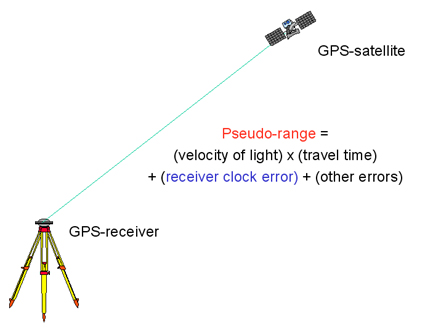

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [4]:
df_pseudorange = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/engg680_2024_fall/Lab_Assignment3/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/engg680_2024_fall/Lab_Assignment3/satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

#print (pseudorange)
#print (sat_pos)

n = pseudorange.size
#print(n)

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [5]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918]) #actual position of receiver

Step 0.4: Intialize empty arrays

In [6]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [7]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [8]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
# Useing the euclidean_norm function to compute the geometric distance between receiver and satellites
   predicted_pseudorange = euclidean_norm(r_pos, s_pos) + cdT

# Calculate the residuals
   residuals = pseudorange - predicted_pseudorange

# Compute the sum of squared residuals
   L = np.sum(residuals**2)/ n

   return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [9]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
    n = len(pseudorange)
    grad = np.zeros(4)

    # Compute the residuals
    predicted_pseudorange = euclidean_norm(r_pos, s_pos) + cdT
    residuals = pseudorange - predicted_pseudorange

    # compute the gradient of each satellite
    for i in range(n):
        # Derivatives with respect to receiver's position
        diff = r_pos - s_pos[i]
        distance = np.linalg.norm(diff)

        if distance != 0:  #Update grad[0] for x_r, y_r and z_r

            grad[0] = grad[0] + 2 * residuals[i] * (-diff[0] / distance)

            grad[1] = grad[1] + 2 * residuals[i] * (-diff[1] / distance)

            grad[2] = grad[2] + 2 * residuals[i] * (-diff[2] / distance)

    # Partial derivative with respect to cdT (clock bias)
    grad[3] = -2 * np.sum(residuals)

    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [10]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.01, max_iters=100000, tolerance=1e-6):
    global steps_count

    # Initialize the estimates as zeros (x_r, y_r, z_r, cdT)
    X = np.array([0, 0, 0, 0])

    for iteration in range(max_iters):
        # Extract receiver position and clock offset from X
        r_pos = X[:3]
        cdT = X[3]

        # cost in the current step
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # gradients in the current step
        grad = gradient(r_pos, cdT, s_pos, pseudorange)

        # estimates using gradient descent
        X_new = X - learning_rate * grad

        # new cost after the update
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # Break the loop (convergence)
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged!")
            steps_count = iteration
            break

        # Update the parameters
        X = X_new

        # Collect intermediate results
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3] - GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [11]:
#Assuming pseudorange, sat_pos, and GroundTruth are already defined

# use gradient_descent to optimize the parameters
optimized_params = gradient_descent(pseudorange, sat_pos)

# Compute final position error and other metrics
final_gradient = gradient(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)
final_cost = cost_function(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)
final_position_error = optimized_params[:3] - GroundTruth

# Print
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Gradient Values:", final_gradient)
print("Final Cost Value:", final_cost)
print("Final Position Errors of Receiver:", final_position_error)

Converged!
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162953e+06  4.95248539e+06  6.44954762e+00]
Number of Steps Taken for Convergence: 2700
Final Gradient Values: [ 0.00161511  0.00899931 -0.02765869 -0.0156805 ]
Final Cost Value: 0.563436913173813
Final Position Errors of Receiver: [-3.06252556 -2.346982    3.77353113]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

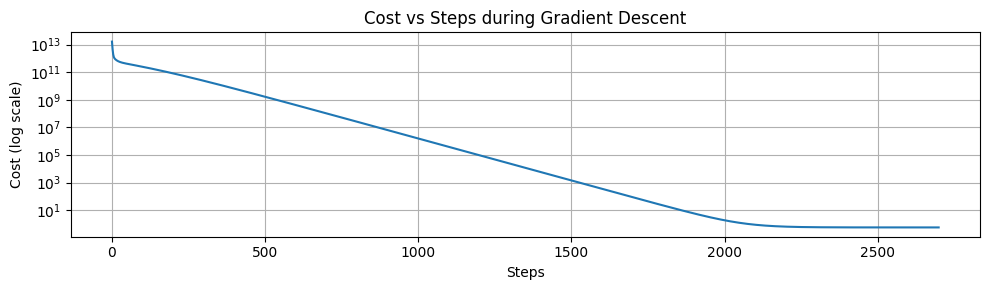

In [12]:
#Cost vs Steps Plot & Analysis

# Create the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

# Plot cost vs. steps using a logarithmic scale for the y-axis
ax.semilogy(arr_cost,)

# Labels, title, grid, adjust layout, show
ax.set_xlabel('Steps')
ax.set_ylabel('Cost (log scale)')
ax.set_title('Cost vs Steps during Gradient Descent')
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# The plot shows initial decrease in gradient values. ⁤⁤As the steps progress, the gradients converge toward zero, suggesting the algorithm is near to the optimal solution and gradients are stabilizing.

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

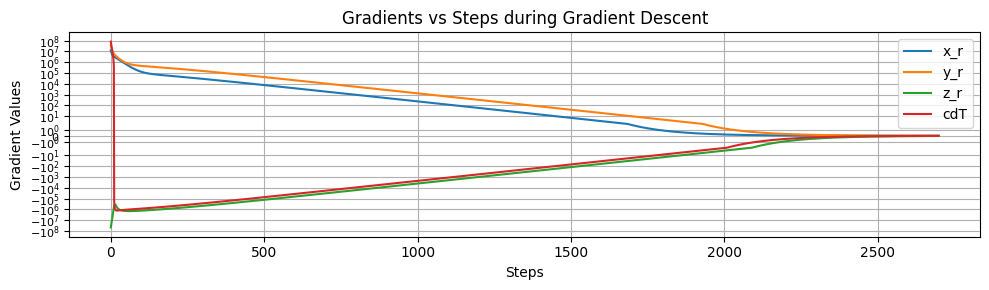

In [13]:
# Create the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(arr_grad)

# Set y-axis to symmetric logarithmic scale
ax.set_yscale('symlog')

# Use tick_params to set y-axis label size to 8
ax.tick_params(axis='y', labelsize=8)

# Labels, title, grid, adust layout, legend and show
ax.set_xlabel('Steps')
ax.set_ylabel('Gradient Values')
ax.set_title('Gradients vs Steps during Gradient Descent')
ax.grid(True)
fig.tight_layout()
plt.legend(['x_r', 'y_r', 'z_r', 'cdT'])
plt.show()

# Comment on the pattern
# The plot shows initial decrease in gradient values. ⁤⁤As the steps progress, the gradients converge toward zero, suggesting the algorithm is near to the optimal solution and gradients are stabilizing.


### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

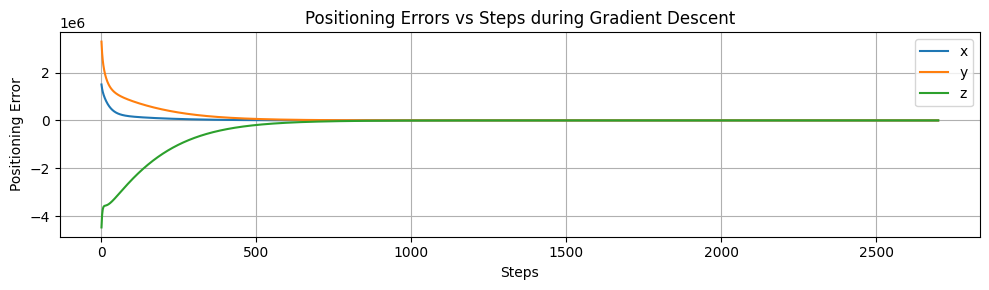

In [14]:
#Positioning errors vs Steps & Analysis)

# Create the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

# Plot positioning errors for each component (x, y, z) vs steps
ax.plot(arr_err)

# Labels, title, grid, adust layout, legend and show
ax.set_xlabel('Steps')
ax.set_ylabel('Positioning Error')
ax.set_title('Positioning Errors vs Steps during Gradient Descent')
ax.grid(True)
fig.tight_layout()
plt.legend(['x', 'y', 'z'])
plt.show()

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [15]:
#set learning rate to 0.01
#re-initialize arrays and counters
# learning rate to 0.01 and maximun iteration 150000
results = {}
arr_cost = []    #re-initializing arrays and counters
arr_grad = []
arr_err = []
steps_count = 0

optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate=0.01, max_iters=150000)
final_position_error = optimized_params_2[:3] - GroundTruth
results[(0.01, 150000)] = {
    "learning_rate": 0.01,
    "max_iters": 150000,
    "optimized_params": optimized_params_2,
    "steps_count": steps_count,
    "final_position_error": final_position_error
}

# Prints
print("Learning rate: 0.01, Max iterations: 150000")
print(f"Optimized Parameters: {results[(0.01, 150000)]['optimized_params']}")
print(f"Steps Count: {results[(0.01, 150000)]['steps_count']}")
print(f"Final Position Error: {results[(0.01, 150000)]['final_position_error']}")

Converged!
Learning rate: 0.01, Max iterations: 150000
Optimized Parameters: [-1.63349244e+06 -3.65162953e+06  4.95248539e+06  6.44954762e+00]
Steps Count: 2700
Final Position Error: [-3.06252556 -2.346982    3.77353113]


In [16]:
# learning rate to 0.001 and maximun iteration 200000
#re-initialize arrays and counters
results = {}
arr_cost = []     #re-initializing arrays and counters
arr_grad = []
arr_err = []
steps_count = 0

optimized_params_3 = gradient_descent(pseudorange, sat_pos, learning_rate=0.001, max_iters=200000)
final_position_error = optimized_params_3[:3] - GroundTruth
results[(0.001, 200000)] = {
    "learning_rate": 0.001,
    "max_iters": 200000,
    "optimized_params": optimized_params_3,
    "steps_count": steps_count,
    "final_position_error": final_position_error
}

# Prints
print("Learning rate: 0.001, Max iterations: 200000")
print(f"Optimized Parameters: {results[(0.001, 200000)]['optimized_params']}")
print(f"Steps Count: {results[(0.001, 200000)]['steps_count']}")
print(f"Final Position Error: {results[(0.001, 200000)]['final_position_error']}")

Converged!
Learning rate: 0.001, Max iterations: 200000
Optimized Parameters: [-1.63349244e+06 -3.65162950e+06  4.95248531e+06  6.40077571e+00]
Steps Count: 25431
Final Position Error: [-3.05750202 -2.31899094  3.68750284]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

---
Q1_Ans. When learning rate reduced from 0.01 to 0.001 the algoritom took more iterations to converge. the final accuracy was similar but the higher learning rate converged faster, while the lower rate required more steps for stability.

Q2_Ans. LSE gives a solution by directly minimizing the sum of squared residuals by using matrix operations. This is fast for smaller problems but becomes slower for larger datasets. On the other hand, Gradient Descent solves iteratively by adjusting the parameters step by step based on gradients. As we can see ours results that, it takes more time to converge but flexible as well as efficient while using complex or larger datasets.

---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [ ]:
!pip install ucimlrepo

In [ ]:
from os import name
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
x= pd.DataFrame(phishing_websites['data']['features'])
y= pd.Series(phishing_websites['data']['targets'].values.ravel(), name="target")

# TO DO: display sizes of X and y (1 mark)
# TO DO: display sizes of X and y (1 mark)
print('Size of X :', x.shape)
print('Size of y :', y.shape)

Size of X : (11055, 30)
Size of y : (11055,)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

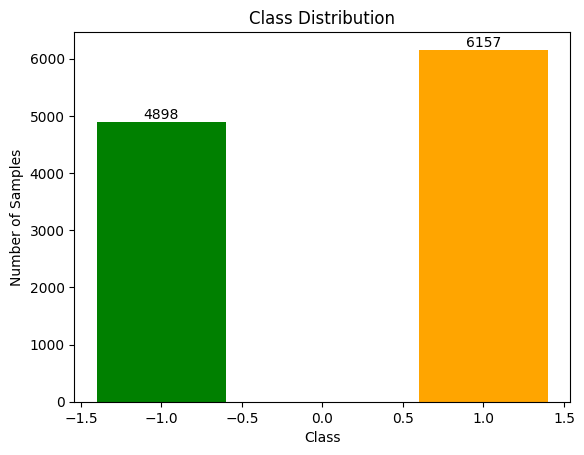

In [ ]:
# TO DO: Check the class distribution of y (2 mark)
class_counts = y.value_counts()

# TO DO: Plot the histogram of y (2 mark)
plt.bar(class_counts.index, class_counts.values, color=['orange' , 'green'])
for idx, val in enumerate(class_counts.values):
    plt.text(class_counts.index[idx], val, str(val), ha='center', va='bottom')

# Display exact values for each bin in the histogram
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [ ]:
# TO DO: Create a smaller dataset with 3% of the data
X_small = x.sample(frac=0.03, random_state=0)
y_small = y.loc[X_small.index]

# TO DO: display sizes of X_small and y_small (2 mark)
print('Size of X_small :', X_small.shape)
print('Size of y_small :', y_small.shape)

Size of X_small : (332, 30)
Size of y_small : (332,)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn

from sklearn.linear_model import LogisticRegression from sklearn.model_selection import train_test_split frtom sklearn.metrics import accuracy_score

2. Instantiate model `LogisticRegression(max_iter=2000)`

model = LogisticRegression(max_iter=2000)

3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)

  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_test=42) model.fit(X_train,y_train)y_pred = model.predict(X_test)
  print("Accuracy with full dataset(X and y):",accuracy_score(y_test,y_pred))

    - Only first two columns of `X` and `y` (1 mark)
  
  X_first_two_cols = X.iloc[:,2]X_train_2,X_test_2,y_train_2,y_test_2 = tarin_test_split(X_first_two_cols,y,test_size=0.3,random_state=42) model.fit(X_train_2,y_train_2)y_pred_2 = model.predict(X_test_2) print("Accuracy with only the first two columns of X:",accuracy_score(y_test_2,y_pred_2))

    - `X_small` and `y_small` (1 mark)

  X_train_small,X_test_small,y_train_small,y_test_small = train_test_split(X_small,y_small,test_size=0.3,random_state=42) model.fit(X_train_small,y_train_small) y_pred_small = model.predict(X_test_small) print("Accuracy with smaller dataset (X_small and y_small):",accuracy_score(y_test_small,y_pred_small))

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)

Full Dataset = 11,055 samples; Smaller Dataset = approx.331 samples

1. number of training samples (1 mark)

Number of samples used for training - 70% of the data

2. number of testing samples (1 mark)

Number of samples used for testing - 30% of the data

4. training accuracy (1 marks)

The accuracy of the model on the training set 5

5. testing accuracy (1 marks)

The accuracy of the model on the testing set 6

6. log loss (1 mark)

Logarithmic Loss on the testing set which provides a measure of the quality of the model's probability predictions.

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [ ]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report

model = LogisticRegression(max_iter=2000)

def evaluate_model(X, y):
    # Split the data into training and testing sets (70% train, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # Fit the model
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)

    # Calculate metrics
    training_accuracy = accuracy_score(y_train, y_train_pred)
    testing_accuracy = accuracy_score(y_test, y_test_pred)
    log_loss_value = log_loss(y_test, y_test_prob)

     # Gather results
    results = {
        "data_size": len(X),
        "training_samples": len(y_train),
        "testing_samples": len(y_test),
        "training_accuracy": training_accuracy,
        "testing_accuracy": testing_accuracy,
        "log_loss": log_loss_value
    }

    return results

results_full = evaluate_model(x, y)
results_first_two = evaluate_model(x.iloc[:, :2], y)
results_small = evaluate_model(X_small, y_small)
results_df = pd.DataFrame({
    "Data size": [results_full['data_size'], results_first_two['data_size'], results_small['data_size']],
    "Training samples": [results_full['training_samples'], results_first_two['training_samples'], results_small['training_samples']],
    "Testing samples": [results_full['testing_samples'], results_first_two['testing_samples'], results_small['testing_samples']],
    "Training accuracy": [results_full['training_accuracy'], results_first_two['training_accuracy'], results_small['training_accuracy']],
    "Testing accuracy": [results_full['testing_accuracy'], results_first_two['testing_accuracy'], results_small['testing_accuracy']],
    "Log loss": [results_full['log_loss'], results_first_two['log_loss'], results_small['log_loss']],
}, index=["Full dataset", "First two columns", "Smaller dataset"])
print(results_df)



                   Data size  Training samples  Testing samples  \
Full dataset           11055              7738             3317   
First two columns      11055              7738             3317   
Smaller dataset          332               232              100   

                   Training accuracy  Testing accuracy  Log loss  
Full dataset                0.932282          0.922822  0.190326  
First two columns           0.562807          0.556828  0.683573  
Smaller dataset             0.931034          0.910000  0.304332  


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [ ]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(x, y, test_size=0.3, random_state=0)
model.fit(X_train_full, y_train_full)
y_test_full_pred = model.predict(X_test_full)


Text(113.9222222222222, 0.5, 'true value')

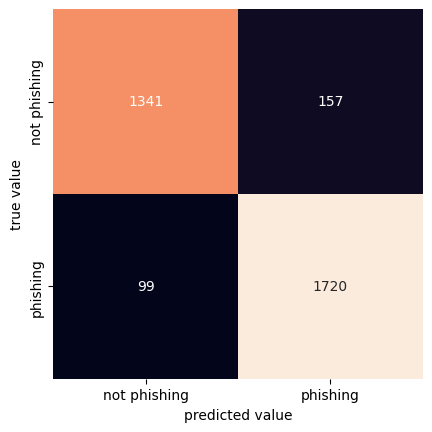

In [ ]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat
conf_mat = confusion_matrix(y_test_full, y_test_full_pred)

# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

In [ ]:
# TO DO: Print classification report (2 marks)
print(classification_report(y_test_full, y_test_full_pred))

              precision    recall  f1-score   support

          -1       0.93      0.90      0.91      1498
           1       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
Q1. The above dataset is imbalanced.This imbalance can impact model effectiveness, as the model might lean towards predicting the more frequent class, potentially overlooking instances of the less common class, which can especially affect recall.

Q2. For Full dataset and the smaller dataset case, the model overfit as the training accuracy is greater than the testing accuracy, indicating that the model memorized specifics rather than general trend.
For the first two colummns case, the model underfit as both training and testing accuracies are lower.

Q3. As the amount of training data increases, training accuracy may slightly drop, but test accuracy typically improves.

Q4. A False Positive (FP) is when the model incorrectly flags a non-phishing email as phishing.
	 A False Negative (FN) is when it fails to recognize an actual phishing email.

In this scenario, false negatives are more critical because missing a phishing email could expose users to security risks.

Q5. To address the higher risk of false negatives, it’s best to focus on maximizing recall for the phishing class. This would make the model more sensitive to phishing, accepting a slightly higher rate of false positives to avoid missing real threats.

Q6. Log Loss is a measure of the model’s confidence in its predictions. A lower log loss implies greater confidence and accuracy. Variations in log loss across cases might stem from factors such as model complexity, data quantity, or class balance.

---